## Importing Libraries

In [1]:
# %pip install tensorflow, keras, keras-tuner, opencv-python, matplotlib, pandas

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras_tuner as kt
import os

from keras.utils import image_dataset_from_directory, load_img
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Rescaling
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.data import AUTOTUNE


## EDA

In [6]:
picture_size = 48
folder_path = "../Ht23-Deep-Learning-Tentamen/images/"

In [4]:
os.listdir(folder_path+"train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

angry


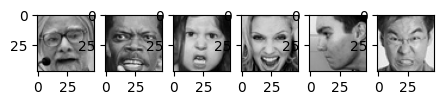

disgust


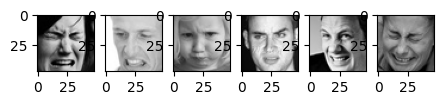

fear


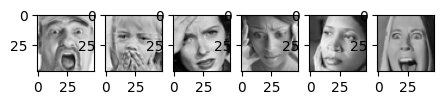

happy


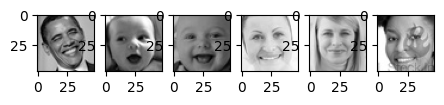

neutral


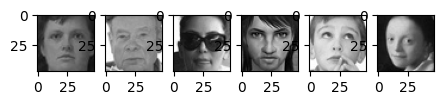

sad


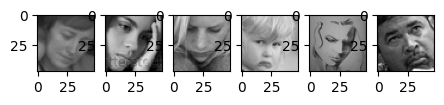

surprise


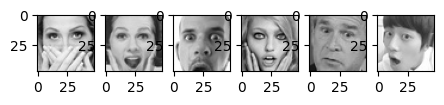

In [5]:
# List of directories containing all expressions
expression = list(os.listdir(folder_path+"train"))

# Plot subplot without labels
for exp in expression:
    plt.figure(figsize= (6,6))
    print(exp)
    for i in range(1, 7, 1):
        plt.subplot(1,7,i)
        img = load_img(folder_path+"train/"+exp+"/"+
                       os.listdir(folder_path + "train/" + exp)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()

# Making Training and Validation Data

In [6]:
# batch_size  = 128

# datagen_train  = ImageDataGenerator()
# datagen_val = ImageDataGenerator()

# train_set = datagen_train.flow_from_directory(folder_path+"train",
#                                               target_size = (picture_size,picture_size),
#                                               color_mode = "grayscale",
#                                               batch_size=batch_size,
#                                               class_mode='categorical',
#                                               shuffle=True)


# test_set = datagen_val.flow_from_directory(folder_path+"validation",
#                                               target_size = (picture_size,picture_size),
#                                               color_mode = "grayscale",
#                                               batch_size=batch_size,
#                                               class_mode='categorical',
#                                               shuffle=False)

In [7]:
batch_size  = 32

# tf.keras.utils.image_dataset_from_directory
train_ds = image_dataset_from_directory(
    folder_path+"train",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size
    )

val_ds = image_dataset_from_directory(
    folder_path+"validation",
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
    )

# Limit datasets to 100 images to speed up training while testing
# train_ds = train_ds.take(100)
# val_ds = val_ds.take(100)

Found 28823 files belonging to 7 classes.
Using 23059 files for training.
Found 7066 files belonging to 7 classes.
Using 1413 files for validation.


In [8]:
# Normalization layer
normalization_layer = Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_val_ds))
# first_image = image_batch[0]

In [9]:
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

In [10]:
# no_of_classes = 7
# input_shape = (picture_size, picture_size, 1)

# model = Sequential()

# # Rescaling layer doesn't work for some reason
# # model.add(Rescaling(scale=1./255))

# #1st CNN layer
# model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# #2nd CNN layer
# model.add(Conv2D(128, 5,padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# #3rd CNN layer
# model.add(Conv2D(512, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# #4th CNN layer
# model.add(Conv2D(512, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Flatten())

# #Fully connected 1st layer
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# # Fully connected layer 2nd layer
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(no_of_classes, activation='softmax'))

# opt = Adam(learning_rate=0.0001)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [11]:
def build_model(hp):
    no_of_classes = 7
    input_shape = (picture_size, picture_size, 1)

    model = Sequential()

    # First convolutional layer with bigger kernel size and stride pick up bigger features
    model.add(
        Conv2D(
            filters=hp.Int("units", min_value=32, max_value=96, step=32),
            kernel_size=7,
            strides=2,
            padding='same',
            activation='relu',
            input_shape=input_shape
        )
    )
    model.add(BatchNormalization())
    if hp.Boolean('use_pooling'):
        model.add(MaxPooling2D(pool_size=2))
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))

    # Tune the number of convolutional layers in the model
    for i in range(hp.Int("conv_layers", 1, 5)):
        model.add(
            Conv2D(
                # Tune the number of filters separately in each convolutional layer
                filters=hp.Int(f"units_{i}", min_value=32, max_value=512, step=16),
                kernel_size=3,
                padding='same',
                activation='relu',
                input_shape=input_shape
            )
        )
        model.add(BatchNormalization())
        if hp.Boolean('use_pooling'):
            model.add(MaxPooling2D(pool_size=2))
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))

    model.add(Flatten())

    # Tune the number of dense layers in the model
    for i in range(hp.Int("dense_layers", 1, 4)):
        model.add(
            Dense(
                # Tune the number of units separately in each dense layer
                hp.Int(f"units_{i}", min_value=32, max_value=512, step=16),
                activation='relu'
            )
        )
        model.add(BatchNormalization())
        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))

    model.add(Dense(no_of_classes, activation='softmax'))

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [12]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20)

tuner.search_space_summary()

Search space summary
Default search space size: 7
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': 'linear'}
use_pooling (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': 'linear'}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [13]:
tuner.search(normalized_train_ds, epochs=10, validation_data=(normalized_val_ds))
best_model = tuner.get_best_models()[0]

Trial 20 Complete [02h 19m 28s]
val_accuracy: 0.5258315801620483

Best val_accuracy So Far: 0.5951875448226929
Total elapsed time: 23h 16m 40s


In [14]:
tuner.results_summary()
best_model = tuner.get_best_models()[0]

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
units: 32
use_pooling: True
dropout: False
conv_layers: 3
units_0: 512
dense_layers: 3
lr: 0.0004965327242071023
units_1: 384
units_2: 144
units_3: 496
units_4: 432
Score: 0.5951875448226929

Trial 01 summary
Hyperparameters:
units: 64
use_pooling: False
dropout: True
conv_layers: 3
units_0: 48
dense_layers: 1
lr: 0.0002522332696647429
units_1: 400
units_2: 160
units_3: 320
units_4: 320
Score: 0.5555555820465088

Trial 13 summary
Hyperparameters:
units: 64
use_pooling: True
dropout: True
conv_layers: 1
units_0: 160
dense_layers: 1
lr: 0.00021098836250509396
units_1: 80
units_2: 208
units_3: 512
units_4: 96
Score: 0.5548478364944458

Trial 05 summary
Hyperparameters:
units: 32
use_pooling: False
dropout: True
conv_layers: 3
units_0: 240
dense_layers: 1
lr: 0.0009035124196037002
units_1: 512
units_2: 128
units_3: 208
units_4: 432
Score: 0

In [14]:
self_trained_model = load_model('model_self_trained.h5')
self_test_loss, self_test_acc = self_trained_model.evaluate(normalized_val_ds, verbose=2)
print('Self-trained test accuracy:', self_test_acc)

ValueError: in user code:

    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py", line 2042, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py", line 2025, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py", line 2013, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py", line 1896, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py", line 1225, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\metrics\accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\utils\metrics_utils.py", line 961, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 7 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:1)' with input shapes: [?,7].


In [15]:
self_trained_model = load_model('model_self_trained.h5')
self_trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       2560      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 256)       1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       590080    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 256)       1

In [16]:
# pre_trained_model = load_model('model_pre_trained.h5')
# pre_test_loss, pre_test_acc = pre_trained_model.evaluate(normalized_val_ds, verbose=2)
# print('Pre-trained test accuracy:', pre_test_acc)

# Fitting the Model with Training and Validation Data 

In [17]:
# from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model_self_trained_v0.3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               restore_best_weights=True
                               )

# Does this do anything?
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001
                                        )

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 100

# model.compile(loss='SparseCategoricalCrossentropy',
#               optimizer = Adam(learning_rate=0.001),
#               metrics=['accuracy']
#               )

In [18]:
# steps_per_epoch and validation_steps commented out due to default values

history = best_model.fit(normalized_train_ds,
                    # steps_per_epoch=train_ds.n//train_ds.batch_size,
                    epochs=epochs,
                    validation_data = normalized_val_ds,
                    # validation_steps = val_ds.n//val_ds.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/100
721/721 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.6590
Epoch 1: val_accuracy improved from -inf to 0.34324, saving model to .\model_self_trained_v0.3.h5
721/721 [==============================] - 77s 105ms/step - loss: 0.9100 - accuracy: 0.6590 - val_loss: 3.3272 - val_accuracy: 0.3432 - lr: 4.9653e-04
Epoch 2/100
  1/721 [..............................] - ETA: 1:14 - loss: 0.8191 - accuracy: 0.6562

c:\Users\Chris\anaconda3\envs\Ht23-Deep-Learning-Tentamen\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


721/721 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.7300
Epoch 2: val_accuracy did not improve from 0.34324
721/721 [==============================] - 75s 104ms/step - loss: 0.7436 - accuracy: 0.7300 - val_loss: 2.7225 - val_accuracy: 0.2781 - lr: 4.9653e-04
Epoch 3/100
721/721 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.7915
Epoch 3: val_accuracy improved from 0.34324 to 0.38641, saving model to .\model_self_trained_v0.3.h5
721/721 [==============================] - 75s 103ms/step - loss: 0.5764 - accuracy: 0.7915 - val_loss: 2.4335 - val_accuracy: 0.3864 - lr: 4.9653e-04
Epoch 4/100
721/721 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8343
Epoch 4: val_accuracy improved from 0.38641 to 0.40481, saving model to .\model_self_trained_v0.3.h5
721/721 [==============================] - 73s 101ms/step - loss: 0.4603 - accuracy: 0.8343 - val_loss: 2.5419 - val_accuracy: 0.4048 - lr: 4.9653e-04
Epoch 5/100
721

# Plotting Accuracy & Loss

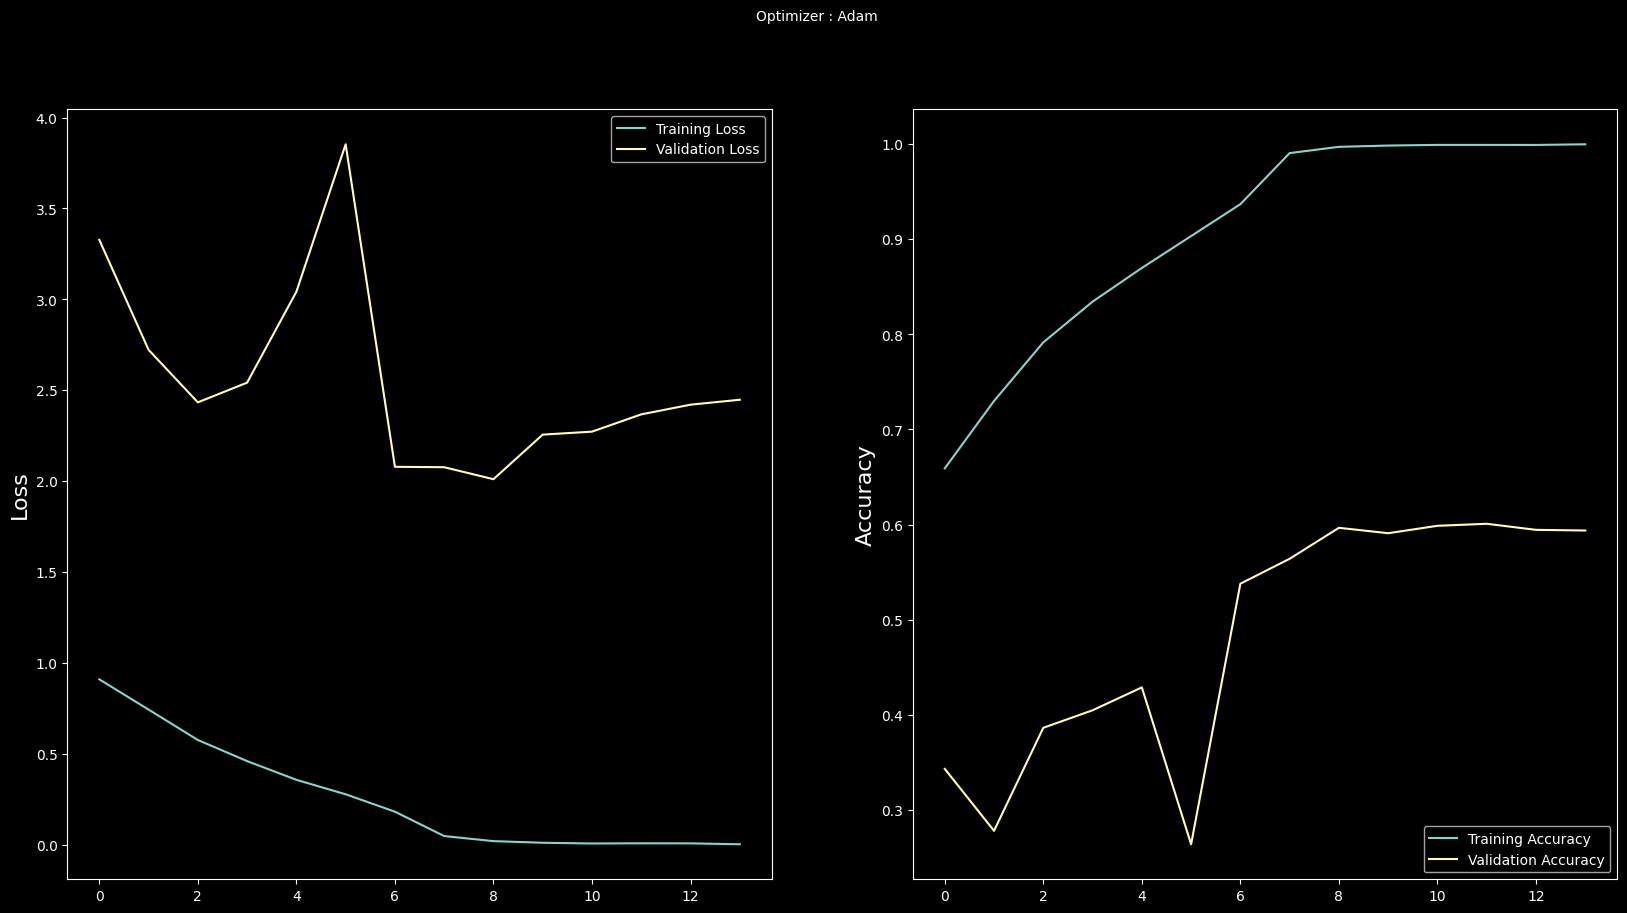

In [19]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()